## **Retrieval Agents** are useful when we want to make decisions about whether to retrieve from an index.To implement a retrieval agent, we simply need to give an LLM access to a retriever tool.

In [4]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters beautifulsoup4

In [36]:
import os
from secret_keys import langsmith_key

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = langsmith_key

In [35]:
from secret_keys import groq_key

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = groq_key

## **Retriever**

First, we index 3 blog posts.

In [37]:
pip install -qU langchain-huggingface

In [11]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 100, chunk_overlap = 50
)
doc_splits = text_splitter.split_documents(docs_list)
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

#Add to vectorDB
embeddings = HuggingFaceEmbeddings()
vectorstore = Chroma.from_documents(doc_splits,collection_name="rag-chroma", embedding=embeddings)

retriever = vectorstore.as_retriever()

Then we create a retriever tool.

In [12]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

## **Agent State**
We will define a graph.

A state object that it passes around to each node.

Our state will be a list of messages.

Each node in our graph will append to it.

In [13]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage],add_messages]

## **Nodes and Edges**
We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next


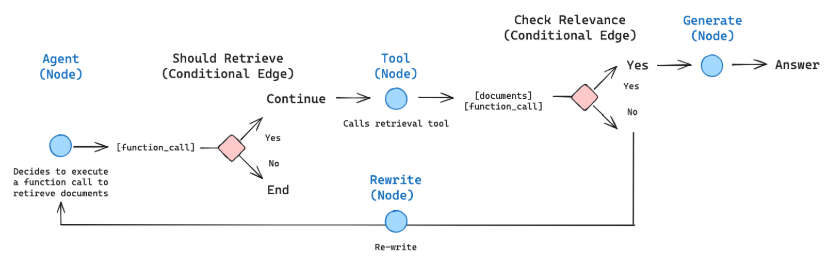

In [14]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.chat_models import init_chat_model

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

In [32]:
!pip install langchain-groq -U --quiet

In [45]:
def grade_documents(state) -> Literal["generate","rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    print("---CHECK RELEVANCE---")

    # Data Model
    class grade(BaseModel):
       binary_score: str = Field(description = "Relevance score 'yes' or 'no'")

    #LLM
    model = init_chat_model("deepseek-r1-distill-llama-70b",model_provider='groq',disable_streaming = False)

    #LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    #Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [46]:
def agent(state):
  print("---CALL AGENT---")
  messages = state["messages"]
  model = init_chat_model("deepseek-r1-distill-llama-70b",model_provider='groq',disable_streaming = False)
  model = model.bind_tools(tools)
  response = model.invoke(messages)

  return {"messages": [response]}

In [47]:
def rewrite(state):
  """
  Transform the query to produce a better question.

  Args:
      state (messages): The current state

  Returns:
      dict: The updated state with re-phrased question
  """
  print("---TRANSFORM QUERY---")
  messages = state["messages"]
  question = messages[0].content

  msg = [
      HumanMessage(
          content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
      )
  ]

  #Grader
  model = init_chat_model("deepseek-r1-distill-llama-70b",model_provider='groq',disable_streaming = False)
  response = model.invoke(msg)
  return {"messages":[response]}

In [48]:
def generate(state):
  """
  Generate answer

  Args:
      state (messages): The current state

  Returns:
      dict: The updated state with re-phrased question
  """
  print("---GENERATE---")
  messages = state["messages"]
  question = messages[0].content
  last_message = messages[-1]

  docs = last_message.content
  # Prompt
  prompt = hub.pull("rlm/rag-prompt")

  # LLM
  llm = init_chat_model("deepseek-r1-distill-llama-70b",model_provider='groq',disable_streaming = False)

  # Post-processing
  def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

  # Chain
  rag_chain = prompt | llm | StrOutputParser()

  # Run
  response = rag_chain.invoke({"context": docs,"question": question})
  return {"messages": [response]}

print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


## **Graph**
Start with an agent, call_model

Agent make a decision to call a function

If so, then action to call tool (retriever)

Then call agent with the tool output added to messages (state)

In [49]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent",agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve",retrieve) # Retrieval
workflow.add_node("rewrite",rewrite) # Re-writing the question
workflow.add_node("generate",generate) # Generating a response after we know the documents are relevant

workflow.add_edge(START,"agent") # Call agent node to decide the retrieve or not

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()






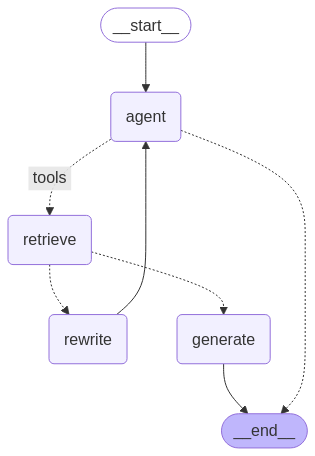

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [53]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content="Lilian Weng discusses various types of memory in the context of large language models (LLMs) and AI agents. She categorizes memory into different types based on their duration, accessibility, and functionality. Here are the key points from her discussions:\n\n1. **Short-Term Memory**: This refers to the temporary storage of information that the model uses during inference or generation. It is limited by the context window that the model can process at one time.\n\n2. **Long-Term Memory**: This is the knowledge that the model has been trained on and retains. It is what allows the model to recall general information, common sense, and patterns learned from the vast amount of text data it was trained on.\n\n3. **Episodic Memory**: This type of memory refers to the ability to remember specific instances or events. In the context of LLMs, episodic memory is limited because models typically do not have the 